### FinBERT IMPLEMENTATION

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
#torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

cpu
cpu


## PRE-PROCESSING

In [5]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation, data splitting, and scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Word embeddings and NLP models
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# TensorFlow utilities
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text  # Uncomment if needed

# PyTorch utilities
import torch

# Optimization utilities
import optuna

# Miscellaneous
from sklearn.preprocessing import LabelEncoder

In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: x86_64
Platform: macOS-10.16-x86_64-i386-64bit
Mac Version: ('10.16', ('', '', ''), 'x86_64')
Processor: i386
Python Version: 3.9.12


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.2.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 6.1.12
jupyter_core     : 4.9.2
jupyter_server   : 1.13.5
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.8
qtconsole        : 5.3.0
traitlets        : 5.1.1


In [9]:
# Specify the path to the dataset, loading the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [10]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [11]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [12]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [13]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [14]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [15]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [16]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


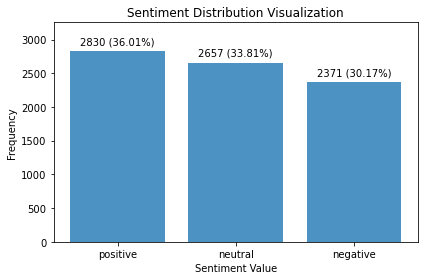

In [17]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [18]:
processed_df

,Headlines,Sentiment
0,spicejet to issue 64 crore warrants to promoters,neutral
1,mmtc q2 net loss at rs 104 crore,neutral
2,midcap funds can deliver more stay put experts,positive
3,mid caps now turn into market darlings,positive
4,market seeing patience if not conviction praka...,neutral
...,...,...
10697,vedantacairn deal may not go through ajay bagga,negative
10700,wall street opens flat sp 500 near record,neutral
10710,heard on the street dutchman mf fiis,neutral
10714,rebound for russia and china lifts stocks,positive


### FINBERT IMPLEMENTATION

In [19]:
def initialize_model_and_tokenizer():
    """
    Initialize the model and tokenizer for the specified pretrained version.

    Returns:
    - tokenizer: Initialized tokenizer
    - model: Initialized model
    """
    model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert', padding=True, truncation=True)
    return tokenizer, model

In [20]:
def process_dataframe(df):
    """
    Maps sentiment to a target value.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'Sentiment' column.

    Returns:
    - pd.DataFrame: Processed DataFrame with an additional 'Target' column.
    """
    target_map = {'neutral': 2, 'positive': 0, 'negative': 1}
    df['Target'] = df['Sentiment'].map(target_map)
    return df

In [21]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")

In [22]:
def prepare_dataset(X, y, tokenizer):
    """
    Prepares the tokenized dataset for training, validation, and testing.

    Parameters:
    - X (np.array): Array of sentences.
    - y (np.array): Array of target values.
    - tokenizer: Tokenizer instance.

    Returns:
    - train_dataset, val_dataset, test_dataset: Torch Dataset objects.
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)


    # Encode data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
    val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

    # Convert encodings into Torch Dataset objects
    train_dataset = SentimentDataset(train_encodings, y_train)
    val_dataset = SentimentDataset(val_encodings, y_val)
    test_dataset = SentimentDataset(test_encodings, y_test)
    return train_dataset, val_dataset, test_dataset, y_test

In [23]:
class SentimentDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for sentiment analysis using tokenized encodings.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
def compute_metrics(pred):
    """
    Compute accuracy for predictions.

    Parameters:
    - pred: Prediction object with `label_ids` and `predictions` attributes.

    Returns:
    - dict: Dictionary containing accuracy.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

In [25]:
def objective(trial, train_dataset, val_dataset, model_init):
    """
    Objective function for optimization. Trains and evaluates a model based on trial parameters.

    Parameters:
    - trial (optuna.trial.Trial): A single trial of hyperparameter optimization.
    - train_dataset: Training dataset.
    - val_dataset: Validation dataset.
    - model_init: Initialization function for the model.

    Returns:
    - float: Evaluation accuracy of the trained model.
    """
    training_args = TrainingArguments(
        output_dir="test_trainer",
        use_mps_device=True,
        num_train_epochs=trial.suggest_int("num_train_epochs", 1, 10),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32, 64]),
        per_device_eval_batch_size=64,
        warmup_steps=trial.suggest_int("warmup_steps", 0, 500),
        weight_decay=trial.suggest_float("weight_decay", 0.0, 0.1),
        learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        logging_dir='./logs',
        load_best_model_at_end=True,
        logging_steps=250,
        evaluation_strategy="steps",
        save_steps=500,
        metric_for_best_model='accuracy',
        greater_is_better=True,
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    print(f"Trainer is running on: {trainer.model.device}")
    trainer.train()
    return trainer.evaluate()["eval_accuracy"]

In [26]:
def optimize_hyperparameters(train_dataset, val_dataset, model_init, n_trials=50):
    """
    Conduct hyperparameter optimization using Optuna.

    Parameters:
    - train_dataset: Training dataset.
    - val_dataset: Validation dataset.
    - model_init: Initialization function for the model.
    - n_trials (int, optional): Number of trials. Defaults to 50.

    Returns:
    - optuna.study.Study: Optuna study object with optimization results.
    """
    pruner = optuna.pruners.MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(lambda trial: objective(trial, train_dataset, val_dataset, model_init), n_trials=n_trials)
    return study

In [27]:
def train_with_best_params(train_dataset, val_dataset, model, best_params):
    """
    Train the model with the best hyperparameters obtained from optimization.

    Parameters:
    - train_dataset: Training dataset.
    - val_dataset: Validation dataset.
    - model: Pretrained model.
    - best_params (dict): Dictionary containing the best hyperparameters.

    Returns:
    - Trainer: Trainer object after training.
    """
    training_args = TrainingArguments(
        output_dir="model_dir",
        use_mps_device=True,
        num_train_epochs=best_params["num_train_epochs"],
        per_device_train_batch_size=best_params["per_device_train_batch_size"],
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params["weight_decay"],
        warmup_steps=best_params["warmup_steps"],
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        save_steps=500,
        logging_steps=250,
        metric_for_best_model='accuracy',
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    print(f"Trainer is running on: {trainer.model.device}")
    trainer.train()
    return trainer

In [28]:
def print_study_results(study):
    """
    Print the optimization results of a study.

    Parameters:
    - study: The study object containing trials with their results and associated parameters.

    Output:
    Prints the trial number, its value (accuracy), and its parameters.
    """
    
    print("\nOptimization Results:")
    for i, trial in enumerate(study.trials):
        print(f"Trial {i + 1}:")
        print(f"  Value (Accuracy): {trial.value}")
        print(f"  Params: {trial.params}")
        print("---------------------------")


In [29]:
def plot_losses(trainer):
    """
    Plots the training and validation loss from a trainer's log history.
    
    Parameters:
    - trainer: An object containing the training state and its log history. 
               It is assumed that this object has an attribute 'state' which 
               further has a 'log_history' attribute storing the losses.

    Output:
    Displays a plot with training and validation losses over logging steps.
    """
    # Extract training and validation loss from log history
    training_losses = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
    validation_losses = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]

    # Plot the losses
    plt.plot(training_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Logging Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [42]:
def test_model(trainer, test_dataset,y_true, label_encoder):
    """
    Evaluates the model on a test dataset, prints the evaluation metrics, 
    and visualizes the confusion matrix.
    
    Parameters:
    - trainer: An object responsible for training, evaluating, and predicting.
               This object should have methods `evaluate` and `predict`.
    - test_dataset: Dataset object on which the model is to be evaluated and predictions are to be made.
    - y_true: The true labels for the test dataset.
    - label_encoder: An encoder object that is used to transform labels. 
                     Should have a `classes_` attribute listing all unique class names.
                     
    Outputs:
    - Prints the evaluation loss and accuracy on the test dataset.
    - Prints a classification report with precision, recall, f1-score, and support.
    - Displays a heatmap representation of the confusion matrix.
    """
    # Evaluate on test dataset
    test_results = trainer.evaluate(test_dataset)
    print("\nTest Set Evaluation:")
    print(f"Evaluation Loss: {test_results['eval_loss']}")
    print(f"Evaluation Accuracy: {test_results['eval_accuracy']}")

    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Convert target_names to string
    target_names = [str(label) for label in label_encoder.classes_]

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=target_names, digits =4))

    # Plot confusion matrix using seaborn
    cm = confusion_matrix(y_true, y_pred)

    # Format annotations to integers
    annot = np.array(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = str(int(cm[i, j]))

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=annot, fmt="", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [49]:
def extract_incorrect_samples(trainer, test_dataset, label_encoder, tokenizer):
    """
    Extracts incorrect samples from the test dataset based on the model's predictions.

    This function aims to identify and decode misclassified samples from a given test dataset.
    The output provides up to five sentences from the dataset that the model has incorrectly
    predicted for each sentiment category (positive, negative, neutral).

    Parameters:
    - trainer: An object responsible for model operations. This object should have a `predict` method.
    - test_dataset: Dataset object from which incorrect samples are to be extracted.
    - label_encoder: An encoder object used to transform labels. Should have a `classes_` attribute listing unique class names.
    - tokenizer: Tokenizer object to decode tokenized text samples back into string sentences.

    Returns:
    - sample_sentences: A dictionary with keys as sentiment labels ("positive", "negative", "neutral").
                        Each key contains a nested dictionary with "sentences" (list of decoded sentences)
                        and "probabilities" (model's predicted probabilities for the respective incorrect label).

    Note:
    The function is designed for sentiment analysis tasks with three sentiment categories (positive, negative, neutral).
    It may require modifications for other tasks or categories.
    """
    # Get model predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    # Extract true labels from the test_dataset
    y_true = [sample['labels'].item() for sample in test_dataset]

    # Convert test_dataset to dataframe
    data = {
        'text': [sample['input_ids'] for sample in test_dataset],
        'label': y_true
    }
    df = pd.DataFrame(data)

    # Filter incorrect predictions
    incorrect_df = df[y_pred != df['label']].copy()
    incorrect_df['predicted_label'] = y_pred[y_pred != df['label'].to_numpy()]

    sample_sentences = {
        "positive": {"sentences": [], "probabilities": []},
        "negative": {"sentences": [], "probabilities": []},
        "neutral": {"sentences": [], "probabilities": []}
     }
    
    for label_text, label_num in [("positive", 1), ("negative", 0), ("neutral", 2)]:
    # Filter out incorrect samples for the specific label
        label_incorrect_df = incorrect_df[incorrect_df['label'] == label_num]

    # Sample up to 5 sentences
        num_samples = min(5, len(label_incorrect_df))
        sampled_texts = label_incorrect_df['text'].sample(n=num_samples, random_state=5)
    # Debug: Print out the sampled_texts
    #   print(f"Sampled token sequences for {label_text}:")
    #   print(sampled_texts)
        
    # Decode the tokens back to sentences and get predicted probabilities
        decoded_sentences = [tokenizer.decode(text.numpy(), skip_special_tokens=True) for text in sampled_texts]
        predicted_labels = label_incorrect_df.loc[sampled_texts.index, 'predicted_label']
        predicted_probs = [predictions.predictions[i][pred_label] for i, pred_label in enumerate(predicted_labels)]
    # Debug: Print out the decoded sentences
    #    print(f"Decoded sentences for {label_text}:")
    #    print(decoded_sentences)

    # Store the sentences and probabilities
        sample_sentences[label_text]['sentences'] = decoded_sentences
        sample_sentences[label_text]['probabilities'] = predicted_probs

    return sample_sentences


In [31]:
# 1. Initialize model and tokenizer
tokenizer, model = initialize_model_and_tokenizer()

# 2. Process your dataframe
processed_df = process_dataframe(processed_df)  # Assuming the dataframe is named 'processed_df'

# 3. Prepare the dataset
df_sample = processed_df.sample(frac=0.25, random_state=5)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_sample['Target'].values)
X = df_sample['Headlines'].values

train_dataset, val_dataset, test_dataset, y_true = prepare_dataset(X, y, tokenizer)

y_t = label_encoder.fit_transform(processed_df['Target'].values)
X_t = processed_df['Headlines'].values

train_dataset_t, val_dataset_t, test_dataset_t, y_true_t = prepare_dataset(X_t, y_t, tokenizer)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# 4. Optimize hyperparameters using Optuna
study = optimize_hyperparameters(train_dataset, val_dataset, model_init)
print_study_results(study)


[I 2023-08-20 14:03:43,439] A new study created in memory with name: no-name-64d00872-62d2-413d-96fb-29926d38494f


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:06:49,157] Trial 0 finished with value: 0.7288135593220338 and parameters: {'num_train_epochs': 10, 'per_device_train_batch_size': 64, 'warmup_steps': 416, 'weight_decay': 0.0864178182365929, 'learning_rate': 4.006946584754387e-05}. Best is trial 0 with value: 0.7288135593220338.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.725900,0.628299,0.755932
500,0.622800,0.582620,0.786441


[I 2023-08-20 14:09:10,215] Trial 1 finished with value: 0.7864406779661017 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 178, 'weight_decay': 0.05953659664645361, 'learning_rate': 0.00011849058183535206}. Best is trial 1 with value: 0.7864406779661017.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.770100,0.729751,0.725424


[I 2023-08-20 14:10:16,189] Trial 2 finished with value: 0.7220338983050848 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'warmup_steps': 119, 'weight_decay': 0.026570422078083133, 'learning_rate': 1.9273357280023197e-05}. Best is trial 1 with value: 0.7864406779661017.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.734000,0.663912,0.752542
500,0.653700,0.623177,0.772881
750,0.640300,0.596897,0.776271
1000,0.587800,0.584674,0.796610
1250,0.605400,0.574753,0.793220
1500,0.583100,0.570488,0.796610


[I 2023-08-20 14:15:05,094] Trial 3 finished with value: 0.7966101694915254 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'warmup_steps': 35, 'weight_decay': 0.010844831774157916, 'learning_rate': 6.767340190117872e-05}. Best is trial 3 with value: 0.7966101694915254.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.728000,0.573361,0.779661


[I 2023-08-20 14:16:11,042] Trial 4 finished with value: 0.8101694915254237 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'warmup_steps': 451, 'weight_decay': 0.022720293054870666, 'learning_rate': 0.000693522105434715}. Best is trial 4 with value: 0.8101694915254237.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.748100,0.685002,0.738983


[I 2023-08-20 14:17:16,863] Trial 5 finished with value: 0.7559322033898305 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'warmup_steps': 317, 'weight_decay': 0.02136262824388965, 'learning_rate': 0.0001013144918873407}. Best is trial 4 with value: 0.8101694915254237.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:19:27,571] Trial 6 finished with value: 0.8372881355932204 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 64, 'warmup_steps': 50, 'weight_decay': 0.06290031023039559, 'learning_rate': 0.0023661656003565383}. Best is trial 6 with value: 0.8372881355932204.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.777200,0.725944,0.732203


[I 2023-08-20 14:22:51,830] Trial 7 finished with value: 0.735593220338983 and parameters: {'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'warmup_steps': 323, 'weight_decay': 0.08995642429250524, 'learning_rate': 1.7017878712098978e-05}. Best is trial 6 with value: 0.8372881355932204.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.637900,0.476743,0.823729
500,0.678900,0.862941,0.708475


[I 2023-08-20 14:25:01,930] Trial 8 finished with value: 0.7084745762711865 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'warmup_steps': 480, 'weight_decay': 0.008707000793174813, 'learning_rate': 0.006649994678744354}. Best is trial 6 with value: 0.8372881355932204.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.698300,0.576298,0.783051


[I 2023-08-20 14:27:43,866] Trial 9 finished with value: 0.8033898305084746 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 416, 'weight_decay': 0.09149230988250258, 'learning_rate': 0.0003429655698153725}. Best is trial 6 with value: 0.8372881355932204.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:29:36,131] Trial 10 finished with value: 0.8440677966101695 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 64, 'warmup_steps': 15, 'weight_decay': 0.056417565762603525, 'learning_rate': 0.0025972802613795243}. Best is trial 10 with value: 0.8440677966101695.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:31:27,753] Trial 11 finished with value: 0.8406779661016949 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 64, 'warmup_steps': 6, 'weight_decay': 0.057167535327949846, 'learning_rate': 0.0026892793271674504}. Best is trial 10 with value: 0.8440677966101695.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:33:01,433] Trial 12 finished with value: 0.847457627118644 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 64, 'warmup_steps': 2, 'weight_decay': 0.044354486614017856, 'learning_rate': 0.001563057658262979}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:34:35,089] Trial 13 finished with value: 0.8203389830508474 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 64, 'warmup_steps': 117, 'weight_decay': 0.040528565735494876, 'learning_rate': 0.0011243495127365526}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:35:50,747] Trial 14 finished with value: 0.7932203389830509 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 64, 'warmup_steps': 210, 'weight_decay': 0.0436981404230062, 'learning_rate': 0.007770263469183684}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.533000,0.451679,0.844068


[I 2023-08-20 14:37:24,430] Trial 15 finished with value: 0.847457627118644 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 64, 'weight_decay': 0.07319688927984164, 'learning_rate': 0.0017434571888229327}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.661400,0.534650,0.786441


[I 2023-08-20 14:38:57,014] Trial 16 finished with value: 0.8 and parameters: {'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 114, 'weight_decay': 0.07420377247352274, 'learning_rate': 0.0003789009741885353}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 14:39:23,562] Trial 17 finished with value: 0.7796610169491526 and parameters: {'num_train_epochs': 1, 'per_device_train_batch_size': 16, 'warmup_steps': 72, 'weight_decay': 0.07226682160699228, 'learning_rate': 0.0009866176116726621}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.713500,0.595898,0.793220


[I 2023-08-20 14:40:34,912] Trial 18 finished with value: 0.7898305084745763 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'warmup_steps': 183, 'weight_decay': 0.04466878791057916, 'learning_rate': 0.00019468942253228117}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.684300,0.516456,0.796610


[I 2023-08-20 14:42:29,457] Trial 19 finished with value: 0.8169491525423729 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'warmup_steps': 261, 'weight_decay': 0.035151870447208994, 'learning_rate': 0.0005860381454718034}. Best is trial 12 with value: 0.847457627118644.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.498000,0.412760,0.833898


[I 2023-08-20 14:44:50,920] Trial 20 finished with value: 0.8542372881355932 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 82, 'weight_decay': 0.050534541430133535, 'learning_rate': 0.0015626889733172966}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.497800,0.443903,0.820339


[I 2023-08-20 14:47:12,184] Trial 21 finished with value: 0.8338983050847457 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 83, 'weight_decay': 0.048982663250162095, 'learning_rate': 0.0015491344058346092}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.502600,0.453424,0.837288


[I 2023-08-20 14:49:33,605] Trial 22 finished with value: 0.8508474576271187 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 156, 'weight_decay': 0.06815079218801787, 'learning_rate': 0.004713224482642352}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.499400,0.448787,0.827119


[I 2023-08-20 14:52:14,894] Trial 23 finished with value: 0.8305084745762712 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 157, 'weight_decay': 0.049206201111705296, 'learning_rate': 0.00424263180439193}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.418600,0.474839,0.820339


[I 2023-08-20 14:54:36,041] Trial 24 finished with value: 0.8372881355932204 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 1, 'weight_decay': 0.03269497948250701, 'learning_rate': 0.004319340987712404}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.529800,0.593270,0.806780


[I 2023-08-20 14:57:16,820] Trial 25 finished with value: 0.8271186440677966 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 239, 'weight_decay': 0.09919164784952968, 'learning_rate': 0.008781033834690205}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.486700,0.479217,0.830508


[I 2023-08-20 15:00:16,701] Trial 26 finished with value: 0.8338983050847457 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'warmup_steps': 139, 'weight_decay': 0.06617965590492522, 'learning_rate': 0.004113527786603918}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.510700,0.423699,0.840678


[I 2023-08-20 15:02:37,692] Trial 27 finished with value: 0.8508474576271187 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 84, 'weight_decay': 0.05471679062278576, 'learning_rate': 0.0013323560104672118}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.553400,0.446436,0.833898


[I 2023-08-20 15:04:59,378] Trial 28 finished with value: 0.8305084745762712 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 105, 'weight_decay': 0.052799311997308127, 'learning_rate': 0.0007771235499745618}. Best is trial 20 with value: 0.8542372881355932.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.579600,0.440440,0.830508


[I 2023-08-20 15:07:59,770] Trial 29 finished with value: 0.8576271186440678 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'warmup_steps': 210, 'weight_decay': 0.07830680597137599, 'learning_rate': 0.0010710659975038334}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.655800,0.506375,0.813559


[I 2023-08-20 15:11:19,459] Trial 30 finished with value: 0.8305084745762712 and parameters: {'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'warmup_steps': 295, 'weight_decay': 0.08076634354748458, 'learning_rate': 0.0004559277898826445}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.581000,0.514589,0.793220


[I 2023-08-20 15:14:20,074] Trial 31 finished with value: 0.847457627118644 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'warmup_steps': 219, 'weight_decay': 0.06595275278856609, 'learning_rate': 0.0010501427277445235}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.611000,0.478292,0.827119


[I 2023-08-20 15:17:00,349] Trial 32 finished with value: 0.847457627118644 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 173, 'weight_decay': 0.060478100667010155, 'learning_rate': 0.0005744167391261727}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.544200,0.448590,0.837288


[I 2023-08-20 15:19:22,738] Trial 33 finished with value: 0.8372881355932204 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 145, 'weight_decay': 0.07948952365077948, 'learning_rate': 0.0013234870280065183}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.675000,0.525449,0.796610


[I 2023-08-20 15:21:26,131] Trial 34 finished with value: 0.7932203389830509 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 186, 'weight_decay': 0.06482885404944655, 'learning_rate': 0.00024758895171403254}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.540700,0.436181,0.827119


[I 2023-08-20 15:24:26,748] Trial 35 finished with value: 0.8372881355932204 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'warmup_steps': 94, 'weight_decay': 0.05437898403946771, 'learning_rate': 0.0008672425553303243}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.459900,0.439533,0.820339


[I 2023-08-20 15:27:07,307] Trial 36 finished with value: 0.8305084745762712 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 39, 'weight_decay': 0.06944802891236256, 'learning_rate': 0.0020717186109463484}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.538500,0.486396,0.796610


[I 2023-08-20 15:29:10,164] Trial 37 finished with value: 0.8169491525423729 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 266, 'weight_decay': 0.059883387437752, 'learning_rate': 0.0031763216600595007}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.626400,0.532826,0.796610
500,0.475600,0.596939,0.803390
750,0.362200,0.479095,0.813559
1000,0.293300,0.494607,0.827119
1250,0.242500,0.537768,0.813559
1500,0.175600,0.471273,0.837288


[I 2023-08-20 15:34:27,351] Trial 38 finished with value: 0.8372881355932204 and parameters: {'num_train_epochs': 10, 'per_device_train_batch_size': 8, 'warmup_steps': 134, 'weight_decay': 0.08192142004567379, 'learning_rate': 0.0017344846346965114}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.528500,0.476187,0.823729


[I 2023-08-20 15:37:28,390] Trial 39 finished with value: 0.8271186440677966 and parameters: {'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'warmup_steps': 360, 'weight_decay': 0.06271065261551571, 'learning_rate': 0.00560494521976}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.523800,0.487018,0.810169


[I 2023-08-20 15:39:51,271] Trial 40 finished with value: 0.8338983050847457 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'warmup_steps': 231, 'weight_decay': 0.05272124694737593, 'learning_rate': 0.0032961045775229004}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:41:26,897] Trial 41 finished with value: 0.823728813559322 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 64, 'warmup_steps': 37, 'weight_decay': 0.04861979186757601, 'learning_rate': 0.0013550535933686523}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:43:21,218] Trial 42 finished with value: 0.8440677966101695 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 64, 'warmup_steps': 56, 'weight_decay': 0.000596843650938636, 'learning_rate': 0.0017260738331816828}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.647300,0.545149,0.800000
500,0.503400,0.492159,0.827119
750,0.345600,0.443406,0.844068


[I 2023-08-20 15:46:05,532] Trial 43 finished with value: 0.8271186440677966 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'warmup_steps': 201, 'weight_decay': 0.05668021917249309, 'learning_rate': 0.002299662625750226}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:47:04,614] Trial 44 finished with value: 0.7694915254237288 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 64, 'warmup_steps': 89, 'weight_decay': 0.05941868221855476, 'learning_rate': 0.0007524871712930556}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.484100,0.411561,0.850847


[I 2023-08-20 15:49:45,898] Trial 45 finished with value: 0.847457627118644 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 24, 'weight_decay': 0.040334013509401564, 'learning_rate': 0.0011729531362079026}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:51:37,935] Trial 46 finished with value: 0.8169491525423729 and parameters: {'num_train_epochs': 6, 'per_device_train_batch_size': 64, 'warmup_steps': 165, 'weight_decay': 0.06867536029652702, 'learning_rate': 0.006297839406171058}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.638100,0.466574,0.830508
500,0.504100,0.467573,0.827119
750,0.370800,0.458472,0.830508
1000,0.268100,0.472788,0.840678


[I 2023-08-20 15:55:19,604] Trial 47 finished with value: 0.8406779661016949 and parameters: {'num_train_epochs': 7, 'per_device_train_batch_size': 8, 'warmup_steps': 123, 'weight_decay': 0.06211821706491504, 'learning_rate': 0.0027774770952546375}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:57:02,251] Trial 48 finished with value: 0.8305084745762712 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 50, 'weight_decay': 0.07524678690313377, 'learning_rate': 0.002384474651380229}. Best is trial 29 with value: 0.8576271186440678.


Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


[I 2023-08-20 15:59:31,674] Trial 49 finished with value: 0.8542372881355932 and parameters: {'num_train_epochs': 8, 'per_device_train_batch_size': 64, 'warmup_steps': 70, 'weight_decay': 0.05322090685793005, 'learning_rate': 0.0019027491153365656}. Best is trial 29 with value: 0.8576271186440678.



Optimization Results:
Trial 1:
  Value (Accuracy): 0.7288135593220338
  Params: {'num_train_epochs': 10, 'per_device_train_batch_size': 64, 'warmup_steps': 416, 'weight_decay': 0.0864178182365929, 'learning_rate': 4.006946584754387e-05}
---------------------------
Trial 2:
  Value (Accuracy): 0.7864406779661017
  Params: {'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 178, 'weight_decay': 0.05953659664645361, 'learning_rate': 0.00011849058183535206}
---------------------------
Trial 3:
  Value (Accuracy): 0.7220338983050848
  Params: {'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'warmup_steps': 119, 'weight_decay': 0.026570422078083133, 'learning_rate': 1.9273357280023197e-05}
---------------------------
Trial 4:
  Value (Accuracy): 0.7966101694915254
  Params: {'num_train_epochs': 9, 'per_device_train_batch_size': 8, 'warmup_steps': 35, 'weight_decay': 0.010844831774157916, 'learning_rate': 6.767340190117872e-05}
---------------------------
Tria

NameError: name 'model_t' is not defined

Trainer is running on: mps:0


/Users/anshulvij/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
250,0.595600,0.495973,0.798134
500,0.425600,0.434460,0.826972
750,0.360300,0.419629,0.842239
1000,0.320300,0.409100,0.844784
1250,0.294700,0.416176,0.844784
1500,0.282000,0.419457,0.842239



Training with Best Parameters:
Evaluation Loss: 0.40909987688064575
Evaluation Accuracy: 0.8447837150127226


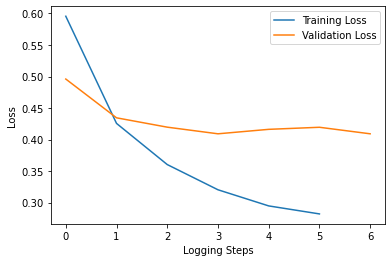


Test Set Evaluation:
Evaluation Loss: 0.36886531114578247
Evaluation Accuracy: 0.8600508905852418
              precision    recall  f1-score   support

           0       0.92      0.84      0.87       437
           1       0.87      0.89      0.88       353
           2       0.80      0.86      0.83       389

    accuracy                           0.86      1179
   macro avg       0.86      0.86      0.86      1179
weighted avg       0.86      0.86      0.86      1179



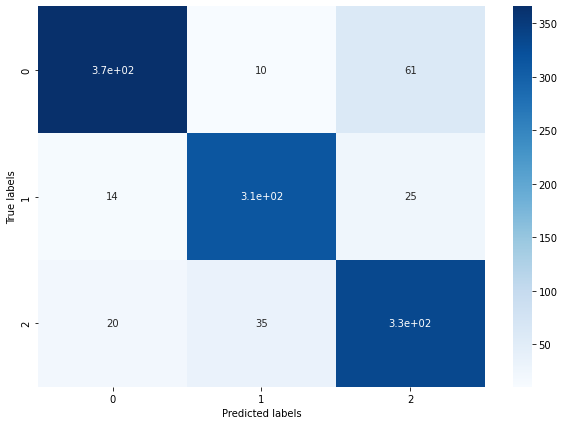


Incorrect positive samples:
1. sentences
2. probabilities

Incorrect negative samples:
1. sentences
2. probabilities

Incorrect neutral samples:
1. sentences
2. probabilities


In [32]:

# 5. Train with the best parameters
best_params = study.best_params
trainer = train_with_best_params(train_dataset_t, val_dataset_t,model, best_params)

# Save the model after optimization
trainer.save_model("model_after_optimization")
model.config.to_json_file("model_after_optimization/config.json")
tokenizer.save_pretrained("model_after_optimization")

# Print the results after training with the best parameters
results = trainer.evaluate()
print("\nTraining with Best Parameters:")
print(f"Evaluation Loss: {results['eval_loss']}")
print(f"Evaluation Accuracy: {results['eval_accuracy']}")

# Plot the losses
plot_losses(trainer)

# Test on the test dataset and print report and confusion matrix
test_model(trainer, test_dataset_t, y_true_t, label_encoder)


In [ ]:
# This is to get specificity and FPR, need to enter the confusion matrix manually to get the results from the above. As best parameters can change based on the trails. 
cm = np.array([[366, 10, 61], 
               [14, 314, 25], 
               [20, 35, 334]])

compute_FPR_spec_metrics(cm)

In [ ]:
# Extract incorrect samples
incorrect_samples = extract_incorrect_samples(trainer, test_dataset_t, label_encoder, tokenizer)

# Print the sentences and probabilities
for label, data in incorrect_samples.items():
    print(f"\nIncorrect {label} samples:")
    for idx, (sentence, prob) in enumerate(zip(data['sentences'], data['probabilities']), 1):
        print(f"{idx}. {sentence} (Probability: {prob:.4f})")

### Reloading the trained model, to print the results properly in the format required. 

In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

# Load model, configuration, and tokenizer
config = AutoConfig.from_pretrained("model_after_optimization/config.json")
model = AutoModelForSequenceClassification.from_pretrained("model_after_optimization", config=config)
tokenizer = AutoTokenizer.from_pretrained("model_after_optimization")

In [37]:
processed_df = process_dataframe(processed_df)
label_encoder = LabelEncoder()
y_t = label_encoder.fit_transform(processed_df['Target'].values)
X_t = processed_df['Headlines'].values

train_dataset_t, val_dataset_t, test_dataset_t, y_true_t = prepare_dataset(X_t, y_t, tokenizer)

In [38]:
from transformers import Trainer, TrainingArguments

# Set up training arguments (assuming you still have best_params from the optimization)
training_args = TrainingArguments(
        output_dir="model_dir",
        use_mps_device=True,
        num_train_epochs=9,
        per_device_train_batch_size=32,
        learning_rate=0.0010710659975038334,
        weight_decay=0.07830680597137599,
        warmup_steps=210,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        save_steps=500,
        logging_steps=250,
        metric_for_best_model='accuracy',
        greater_is_better=True,
)

# Recreate the trainer
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_t,
        eval_dataset=val_dataset_t,
        compute_metrics=compute_metrics,
)



Training with Best Parameters:
Evaluation Loss: 0.40909987688064575
Evaluation Accuracy: 0.8447837150127226

Test Set Evaluation:
Evaluation Loss: 0.36886531114578247
Evaluation Accuracy: 0.8600508905852418
              precision    recall  f1-score   support

           0     0.9150    0.8375    0.8746       437
           1     0.8747    0.8895    0.8820       353
           2     0.7952    0.8586    0.8257       389

    accuracy                         0.8601      1179
   macro avg     0.8616    0.8619    0.8608      1179
weighted avg     0.8634    0.8601    0.8607      1179



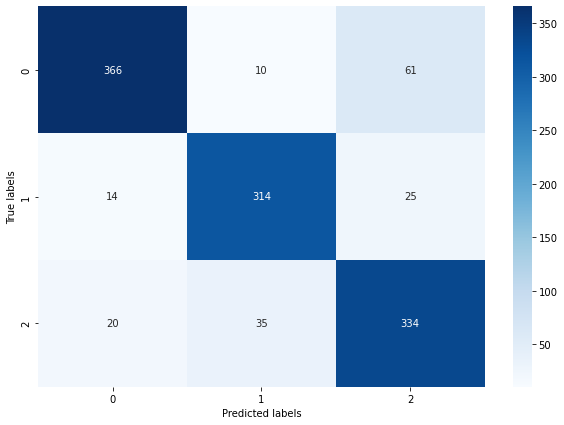

In [43]:
# Evaluate and print the results
results = trainer.evaluate()
print("\nTraining with Best Parameters:")
print(f"Evaluation Loss: {results['eval_loss']}")
print(f"Evaluation Accuracy: {results['eval_accuracy']}")

# Test on the test dataset and print the report and confusion matrix
test_model(trainer, test_dataset_t, y_true_t, label_encoder)


In [44]:
cm = np.array([[366, 10, 61], 
               [14, 314, 25], 
               [20, 35, 334]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.9501
FPR: 0.0499
Precision: 0.915

Metrics for class negative (Class value: 1):
Specificity: 0.9396
FPR: 0.0604
Precision: 0.8747

Metrics for class neutral (Class value: 2):
Specificity: 0.8877
FPR: 0.1123
Precision: 0.7952

Overall accuracy: 0.8601
Weighted average specificity: 0.9264
Weighted average FPR: 0.0736
Macro average specificity: 0.9258
Macro average FPR: 0.0742



In [50]:
# Extract incorrect samples
incorrect_samples = extract_incorrect_samples(trainer, test_dataset_t, label_encoder, tokenizer)

# Print the sentences and probabilities
for label, data in incorrect_samples.items():
    print(f"\nIncorrect {label} samples:")
    for idx, (sentence, prob) in enumerate(zip(data['sentences'], data['probabilities']), 1):
        print(f"{idx}. {sentence} (Probability: {prob:.4f})")


Incorrect positive samples:
1. oil prices tumble to 45 bring cheer to customers (Probability: -1.6323)
2. rupee trims initial losses trades at 6235 vs dlr (Probability: 2.3520)
3. hefty fine for insider trade looms over reliance industries (Probability: -0.5291)
4. fii buying in vmart retail crosses limit no further purchase (Probability: -1.7944)
5. dtc proposal to create volatility in stock markets analysts (Probability: 1.2210)

Incorrect negative samples:
1. omc should be a part of an investors portfolio mehraboon irani (Probability: -0.5123)
2. kingfisher at yearhigh on report of wilbur ross investment plan (Probability: -1.5060)
3. rupee trims losses against us dollar still trading 2 paise down (Probability: 2.9256)
4. leisure revenue buoys cox kings (Probability: -1.7944)
5. punters make a killing in geometric (Probability: -0.2987)

Incorrect neutral samples:
1. investors may not gain much from new structure of crompton greaves (Probability: 2.6486)
2. inflation corporate gove